### part 4 makemore - becoming backprop ninja

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


##### Let's do some awesome coding

In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')


In [6]:
# Create our MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # put 27 characters in 10 dimensional space
# Layer 1 
W1 = torch.randn((n_embd* block_size, n_hidden),  generator=g) * (5/3) / ((n_embd * block_size)**0.5) # gain/sqrt(fan_in) - kaiming normal
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # just for fun, its useless
# there is no use in bias when we use batch norm as it will be subtracted in calculation of mean 
# instead we now have bnbias which is in charge how much we need to shift 
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters 
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))* 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size ## a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # take random 32 examples to use in training
Xb, Yb = Xtr[ix], Ytr[ix] # bach X, Y

<img src="images/batch_norm.png" alt="Batch Norm Screenshot" width="400"/>

In [8]:
# forward pass, chunkated into smaller steps that are possible to backward one at a time 

# forward pass
emb = C[Xb] # [32,3,10] - embed characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
#Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# Batchnorm Layer
# -------------------------
bnmeani = hprebn.mean(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n-1)* (bndiff2).sum(0, keepdim=True) #note: Bessel's correction  (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2 # output layer (32, vocab_size=27)
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits-logit_maxes #subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use  ( 1.0/ counts_sum) instead then I can't get backprop to be bit exact..
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytroch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3375, grad_fn=<NegBackward0>)

In [9]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [10]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
# LOVE IT, some cool ideas gonna code now

#dloss = - 1/3 a  - 1/3 b - 1/3 c -> sum of logprobs[range(n), Yb] / n  - n elements, else is zero in loss above
#dloss/da = -1/3
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n 

# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs
# dlogprobs/dprobs = log(probs)' = 1/probs
dprobs = dlogprobs * (1 / probs)

# dprobs shape (n, vocab_size); counts shape (n, vocab_size); counts_sum_inv (n, 1)
# explaing in simple terms 
# c = a * b  where a(2,2) and b(2,1) => c(2,2) so dc/db1 =a11 + a12 and so on 
#  a11*b1 a12 * b1
#  a21*b2 a22 * b2
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) 
dcounts_sum = dcounts_sum_inv * (-1/counts_sum**2)
# counts presented 2 times in probs and counts_sum so we should sum 2 gradients 
# counts_sum (n, 1) counts(n,vocab_size)
# b1 = a11 + a12 + a13 +.... 
# bn = an1+ an2 + an3 +... 
# so we just route  dcount_sum in each element of dcounts by + dcounts_sum cause db1/daxx = 1
dcounts = dprobs * counts_sum_inv + dcounts_sum # broadcasting, can also say torch.ones_like(counts)*dcounts_sum
# dexp/dx = exp(x)
dnorm_logits = dcounts * counts # counts = norm_logits.exp()
dlogits_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits_2 = torch.zeros_like(logits)
dlogits_2[range(n), torch.argmax(logits, dim=1)] += dlogits_maxes.reshape(-1)
# 2nd solution using one hot looks more beautiful and logical
dlogits_2 = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes 
# sum of norm_logits and logits_maxes gradients
dlogits = dnorm_logits.clone() + dlogits_2 

dh = dlogits @ W2.T # (n,vocab_size) @ (vocab_size, hidden) = (n,hidden) = h.shape
dW2 = h.T @ dlogits # (hidden, n) @ (n, vocab_size) = (hidden, vocab_size) = W2.shape
db2 = dlogits.sum(0) #(n, vocab_size).sum(0) = (vocab_size) = b2.shape 

# dtanh(h) = 1 - tanh(h)**2
dhpreact = dh * (1 - h**2) #(n, hidden)
dbngain = (dhpreact * bnraw).sum(0, keepdim=True) #(1,hidden)
dbnbias = dhpreact.sum(0, keepdim=True) # (1,hidden)
dbnraw = dhpreact * bngain #(n, hidden)

# dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True) # (1, hidden)
dbnvar = dbnvar_inv * ((-1/2) * (bnvar + 1e-5)**(-3/2)) # (1, hidden)
dbndiff2 = dbnvar * (1/(n-1)) * torch.ones_like(bndiff2) # (n, hidden)
dbndiff = dbnraw * bnvar_inv + dbndiff2 * 2 * bndiff

dbnmeani = -dbndiff.sum(0, keepdim=True)
# sum of bndiff and bnmeani gradients 
dhprebn = dbndiff + dbnmeani * (1/n) * torch.ones_like(hprebn)

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
# print( F.one_hot(Xb.view(-1), num_classes=vocab_size).shape)
# print(demb.view(-1, n_embd).shape)

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits_maxes', dlogits_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [11]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now 
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.3375468254089355 diff: -2.384185791015625e-07


In [12]:
ps = F.softmax(logits, dim=1)
dlogits = ps.clone()
dlogits[range(n), Yb] -= 1.0 
dlogits /= n

cmp('logits', dlogits, logits) # not exact because we have logits.max  I am guessing

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [13]:
F.softmax(logits, 1)[0]

tensor([0.0676, 0.0984, 0.0187, 0.0473, 0.0191, 0.0827, 0.0252, 0.0347, 0.0179,
        0.0324, 0.0374, 0.0369, 0.0358, 0.0276, 0.0362, 0.0127, 0.0085, 0.0191,
        0.0149, 0.0527, 0.0462, 0.0225, 0.0266, 0.0715, 0.0573, 0.0290, 0.0210],
       grad_fn=<SelectBackward0>)

In [14]:
print(dlogits[0] * n)
print(dlogits[0].sum())

tensor([ 0.0676,  0.0984,  0.0187,  0.0473,  0.0191,  0.0827,  0.0252,  0.0347,
        -0.9821,  0.0324,  0.0374,  0.0369,  0.0358,  0.0276,  0.0362,  0.0127,
         0.0085,  0.0191,  0.0149,  0.0527,  0.0462,  0.0225,  0.0266,  0.0715,
         0.0573,  0.0290,  0.0210], grad_fn=<MulBackward0>)
tensor(1.8626e-09, grad_fn=<SumBackward0>)


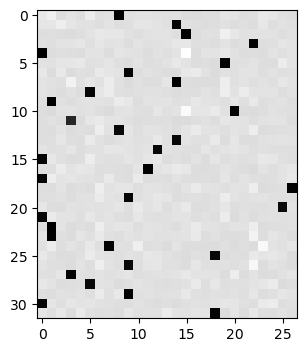

In [15]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [16]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = hprebn.mean(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) (unbiased)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [17]:
bnvar.shape, hprebn.shape, bnraw.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [18]:
# backward pass 

# before
# dhpreact = dh * (1 - h**2) #(n, hidden)
# dbngain = (dhpreact * bnraw).sum(0, keepdim=True) #(1,hidden)
# dbnbias = dhpreact.sum(0, keepdim=True) # (1,hidden)
# dbnraw = dhpreact * bngain #(n, hidden)

# # dbndiff = dbnraw * bnvar_inv
# dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True) # (1, hidden)
# dbnvar = dbnvar_inv * ((-1/2) * (bnvar + 1e-5)**(-3/2)) # (1, hidden)
# dbndiff2 = dbnvar * (1/(n-1)) * torch.ones_like(bndiff2) # (n, hidden)
# dbndiff = dbnraw * bnvar_inv + dbndiff2 * 2 * bndiff

# dbnmeani = -dbndiff.sum(0, keepdim=True)
# # sum of bndiff and bnmeani gradients 
# dhprebn = dbndiff + dbnmeani * (1/n) * torch.ones_like(hprebn)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)
dhprebn = bngain * bnvar_inv * (dhpreact  - (1/n) * dhpreact.sum(0, keepdim=True) - 1/(n-1) * bnraw * (dhpreact * bnraw).sum(0, keepdim=True))
# don't need keepdim tbh                              

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [19]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# Create our MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) 
# Layer 1 
W1 = torch.randn((n_embd* block_size, n_hidden),  generator=g) * (5/3) / ((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters 
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))* 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time 
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written
with torch.no_grad():

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # take random 32 examples to use in training
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # [32,3,10] - embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
        # Linear layer
        hprebn = embcat @ W1  + b1 # hidden layer pre activation 
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True) #note: Bessel's correction  (dividing by n-1, not n)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # we also want scale and shift in future, not always have gausssian distribution, so we add bngain and bnbias to be able learn to shift neurons
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer (32, 200)
        logits = h @ W2 + b2 # output layer (32, 27)
        loss = F.cross_entropy(logits, Yb) #  loss function 
        
        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        ps = F.softmax(logits, dim=1)
        dlogits = ps.clone()
        dlogits[range(n), Yb] -= 1.0 
        dlogits /= n
        # logits = h @ W2 + b2
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # non-linearity
        dhpreact = dh * (1 - h**2)
        # Batchnorm Layer 
        dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
        dbnbias = (dhpreact).sum(0, keepdim=True)
        dhprebn = bngain * bnvar_inv * (dhpreact  - (1/n) * dhpreact.sum(0, keepdim=True) - 1/(n-1) * bnraw * (dhpreact * bnraw).sum(0, keepdim=True))
        # hprebn = embcat @ W1 + b1  - linear layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embcat = emb.view(emb.shape[0], -1)
        demb = dembcat.view(emb.shape)
        # emb = C[Xb] # [32,3,10]
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k,j]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update 
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable
        
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) 

        # if i >= 2:
        #     break

12297
      0/ 200000: 3.7810
  10000/ 200000: 2.1652
  20000/ 200000: 2.3942
  30000/ 200000: 2.4365
  40000/ 200000: 2.0136
  50000/ 200000: 2.3970
  60000/ 200000: 2.3913
  70000/ 200000: 2.0495
  80000/ 200000: 2.4180
  90000/ 200000: 2.1646
 100000/ 200000: 1.9872
 110000/ 200000: 2.3362
 120000/ 200000: 1.9691
 130000/ 200000: 2.4277
 140000/ 200000: 2.3059
 150000/ 200000: 2.2203
 160000/ 200000: 1.9776
 170000/ 200000: 1.8480
 180000/ 200000: 2.0528
 190000/ 200000: 1.8775


<img src="images/swole_doge.png" alt="Swole Doge" width="500"/>

In [117]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.6763806343078613e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(200,)          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [20]:
# calibrate the batch norm at the end of training
# so we could test our examples and could do it to different sizes, can be 1 sample 
# and we don't need to take batch and do always  dynamic batch normalization

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # dynamic batch normalization at test time
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070709228515625
val 2.1101233959198


In [ ]:
# I achieved:
# train 2.070709228515625
# val 2.1101233959198

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahza.
jahmarik.
mrex.
taty.
skanden.
jazhita.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
joce.
quinn.
saline.
liven.
coraelogiearyn.
kai.
eugius.
brex.


In [ ]:
# c11 c12 c13 =  a11 a12 a13   b1
# c21 c22 c23 =  a21 a22 a23 - b2
# c31 c32 c33 =  a31 a32 a33   b3

#so e.g.  c32 = a32 - b3 so dc32/da32 = 1 and dc32/db3 = 1